# Курсовая работа 

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [77]:
#Импорт нужных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

#Загружаю датафреймы
folder='C:/Users/О/Desktop/ДЗ'
train_df = pd.read_csv(folder + '/train.csv')
test_df = pd.read_csv(folder + '/test.csv')

#Экономлю память, функцию взяла в:https://www.kaggle.com/code/konstantinalbul/real-estate-price-prediction
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    #df.info()
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    #df.info()
    return df

train_df=reduce_mem_usage(train_df)
test_df=reduce_mem_usage(test_df)

In [78]:
#Процентный список пропущенных данных
for col in train_df.columns:
    pct_missing = np.mean(train_df[col].isnull())
    if pct_missing==0:
        continue
    else:
        print('{} - {}%'.format(col, round(pct_missing*100)))

LifeSquare - 21%
Healthcare_1 - 48%


In [79]:
#Обработка пропусков. Пропуски заполняются средними значениями:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['LifeSquare'].mean()
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mean()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

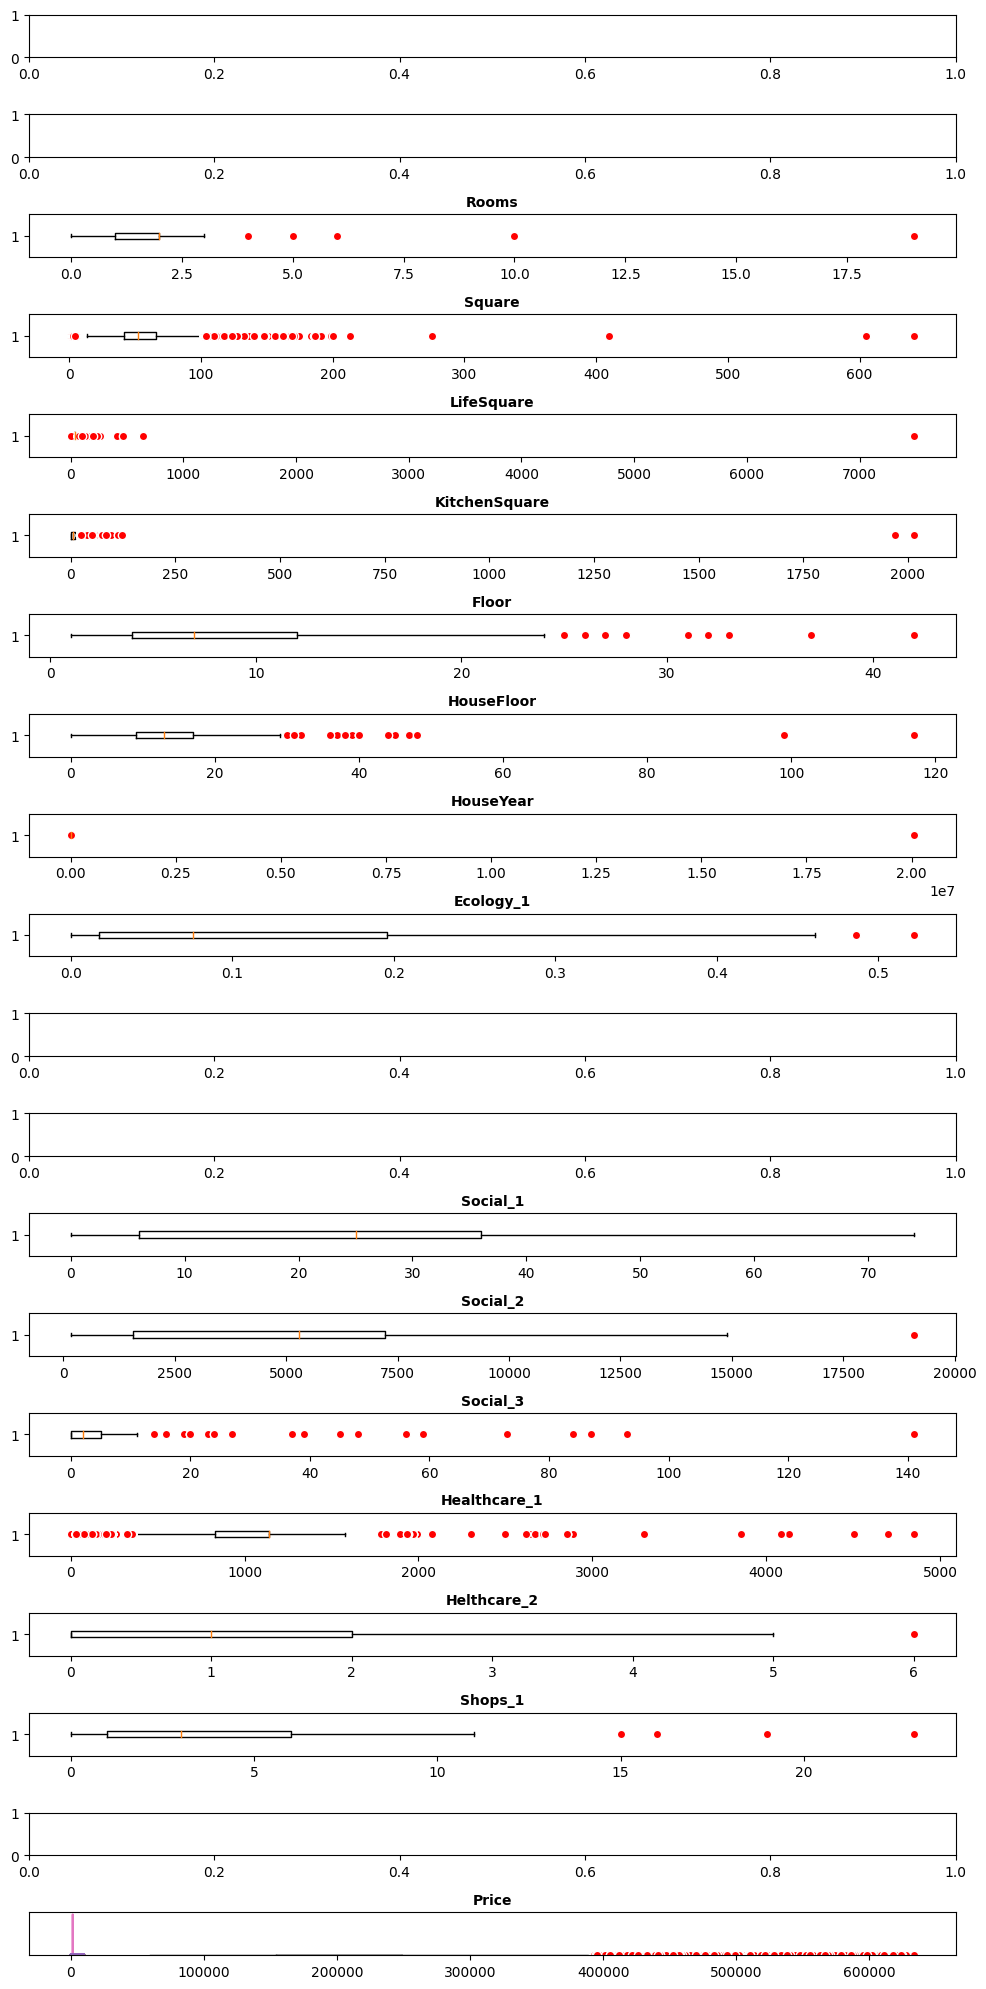

In [80]:
#Анализ данных на выбросы
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(len(train_df.columns), 1, figsize=(10,20))
fig. tight_layout (h_pad= 2 )

for i, ax in enumerate(axs.flat):
    if i in [0, 1, 10, 11, 18]: #убираю из цикла все, что object
        continue
    else:
        ax.boxplot(train_df.iloc[:,i], vert=False, flierprops=red_circle)
        ax.set_title(train_df.columns[i], fontsize=10, fontweight='bold')
        ax.tick_params(axis='y', labelsize=10)
        train_df.iloc[:,i].plot()

In [81]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,10000.0,37.199642,76.588745,0.370619,25.527400,37.199646,41.427234,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


In [82]:
#Заменяю выбросы на медианы
def outlier_detect(df):
    for i in df.describe().columns:
        Q1=df.describe().at['25%',i]
        Q3=df.describe().at['75%',i]
        IQR=Q3 - Q1
        LTV=Q1 - 1.5 * IQR
        UTV=Q3 + 1.5 * IQR
        x=np.array(df[i])
        p=[]
        for j in x:
            if j < LTV or j>UTV:
                p.append(df[i].median())
            else:
                p.append(j)
        df[i]=p
    return df

outlier_detect(train_df)
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
DistrictId,10000.0,46.497200,38.060689,0.000000,20.000000,36.000000,67.000000,157.000000
Rooms,10000.0,1.851400,0.758403,0.000000,1.000000,2.000000,2.000000,3.000000
Square,10000.0,54.654774,15.859586,13.784864,41.794393,52.513309,64.682945,102.056969
LifeSquare,10000.0,34.241356,10.912247,1.726270,25.891666,37.199646,37.426077,65.224602
KitchenSquare,10000.0,5.677200,3.877667,0.000000,1.000000,6.000000,9.000000,21.000000
Floor,10000.0,8.398500,5.029714,1.000000,4.000000,7.000000,12.000000,24.000000
HouseFloor,10000.0,12.481500,6.395479,0.000000,9.000000,13.000000,17.000000,29.000000
HouseYear,10000.0,1985.052600,18.050225,1934.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.116213,0.115070,0.000000,0.017647,0.075424,0.194489,0.460556


C:\Users\О\AppData\Local\Temp\ipykernel_5788\2025601959.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['Price'], bins=50)


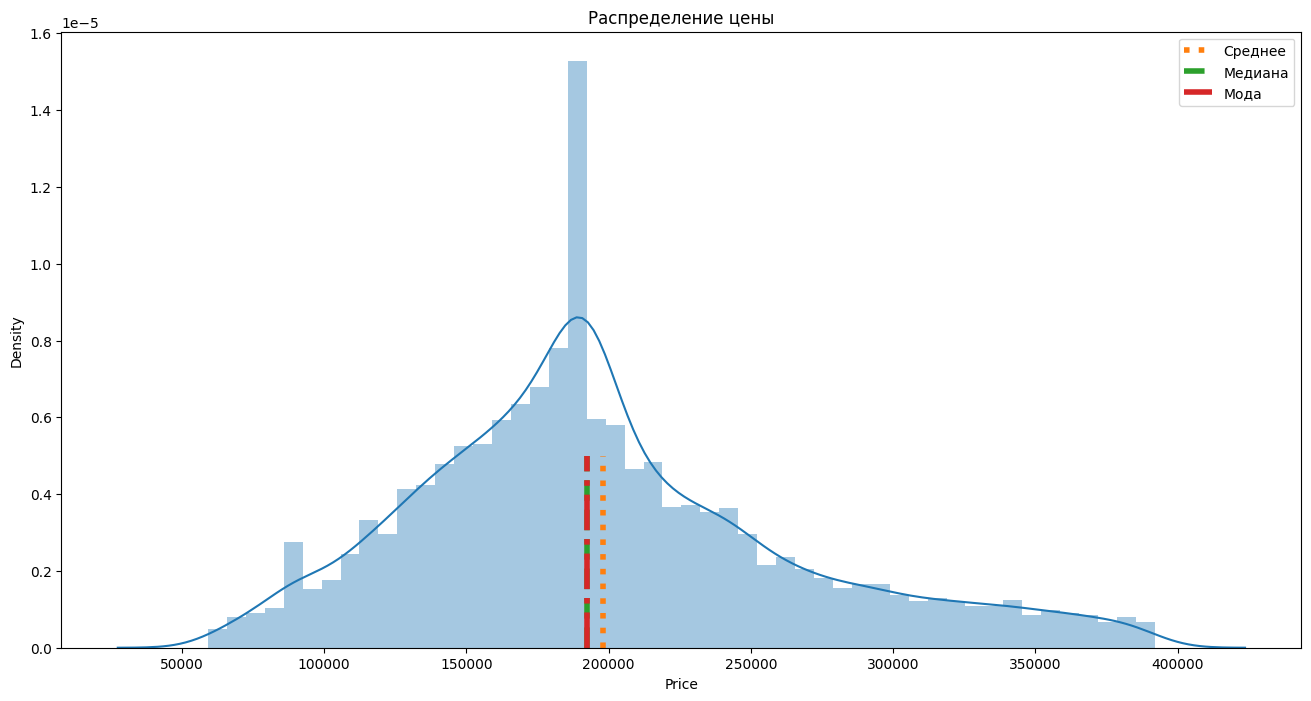

In [83]:
#
train_mean = round(train_df['Price'].mean(), 2)
train_median = train_df['Price'].median()
train_mode =train_df['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([train_mean] * 10, y, label='Среднее', linestyle=':',  linewidth=4)
plt.plot([train_median] * 10, y, label='Медиана', linestyle='--',  linewidth=4)
plt.plot([train_mode] * 10, y, label='Мода', linestyle='-.', linewidth=4)

plt.title('Распределение цены')#Получилось не слишком равномерным, потому что было много выбросов, которые заменила на медиану
plt.legend()

C:\Users\О\AppData\Local\Temp\ipykernel_5788\2303262527.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


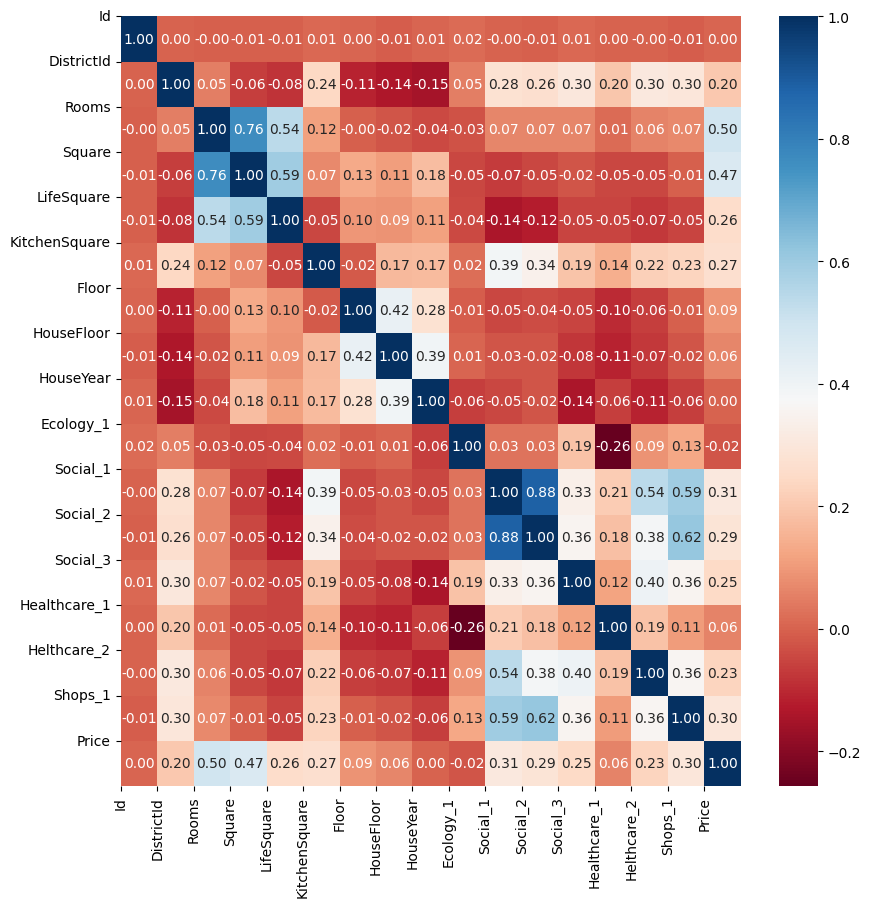

In [84]:
#train_df["SquareMeterPrice"] = train_df["Price"] / train_df["Square"]
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [85]:
#Анализ параметра Price. В итоговую модель не войдут параметры, у которых взаимная корреляция больше 0,7 
#И у которых корреляция с Price по модулю ниже, чем 0,3 

feature_names = ['DistrictId','Rooms','Square','LifeSquare','Floor','KitchenSquare', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Healthcare_1', 'Shops_1', 'Square']
target_name = 'Price'

In [86]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)
y_valid.describe()

count      3300.000000
mean     198298.531250
std       66981.742188
min       59877.593750
25%      153562.464844
50%      190727.281250
75%      232766.128906
max      391982.656250
Name: Price, dtype: float64

In [87]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.means = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медианы и среднего значения
        self.medians = X.median()
        self.means = X.mean()
    
    
    def transform(self, X):
        """Трансформация данных"""
        
       #Обработка пропусков. Пропуски заполняются средними значениями:
        X.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['LifeSquare'].mean()
        X.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mean()
        X.info()
        
       #Обработка пропусков. Пропуски заполняются средними значениями:
        for i in X.describe().columns:
            Q1=X.describe().at['25%',i]
            Q3=X.describe().at['75%',i]
            IQR=Q3 - Q1
            LTV=Q1 - 1.5 * IQR
            UTV=Q3 + 1.5 * IQR
            x=np.array(X[i])
            p=[]
            for j in x:
                if j < LTV or j>UTV:
                    p.append(X[i].median())
                else:
                    p.append(j)
            X[i]=p
        
       # X["SquareMeterPrice"] = X["Price"] / X["Square"]
        
        return X

In [88]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.price_by_district = None      
            
    def fit(self, X):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # price_by_district
        
        X['SquareMeterPrice'] = train_df['Price'] / X['Square']

        
    def transform(self, X):
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # RoomSquare
        X['RoomSquare'] = X['LifeSquare'] / X['Rooms']
        
        # price_by_district
       
        X = X.merge(self.price_by_district, on=["DistrictId"], how='left')
        X.fillna(self.price_by_district_median, inplace=True)
               
        return X

In [89]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

C:\Users\О\AppData\Local\Temp\ipykernel_5788\3507192980.py:12: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.medians = X.median()
C:\Users\О\AppData\Local\Temp\ipykernel_5788\3507192980.py:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.means = X.mean()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 9239 to 5327
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             6700 non-null   int16   
 1   DistrictId     6700 non-null   float64 
 2   Rooms          6700 non-null   float32 
 3   Square         6700 non-null   float32 
 4   LifeSquare     6700 non-null   float32 
 5   KitchenSquare  6700 non-null   float32 
 6   Floor          6700 non-null   float64 
 7   HouseFloor     6700 non-null   float32 
 8   HouseYear      6700 non-null   float64 
 9   Ecology_1      6700 non-null   float32 
 10  Ecology_2      6700 non-null   category
 11  Ecology_3      6700 non-null   category
 12  Social_1       6700 non-null   int8    
 13  Social_2       6700 non-null   float64 
 14  Social_3       6700 non-null   float64 
 15  Healthcare_1   6700 non-null   float32 
 16  Helthcare_2    6700 non-null   float64 
 17  Shops_1        6700 non-null  

((6700, 19), (3300, 19), (5000, 19))

In [90]:
features_gen = FeatureGenetator()
features_gen.fit(X_train)

#X_train = features_gen.transform(X_train)
#X_valid = features_gen.transform(X_valid)
#test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

X_train = X_train[feature_names]
X_valid = X_valid[feature_names]
test_df = test_df[feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 3418)

In [91]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.94
Test R2:	0.57


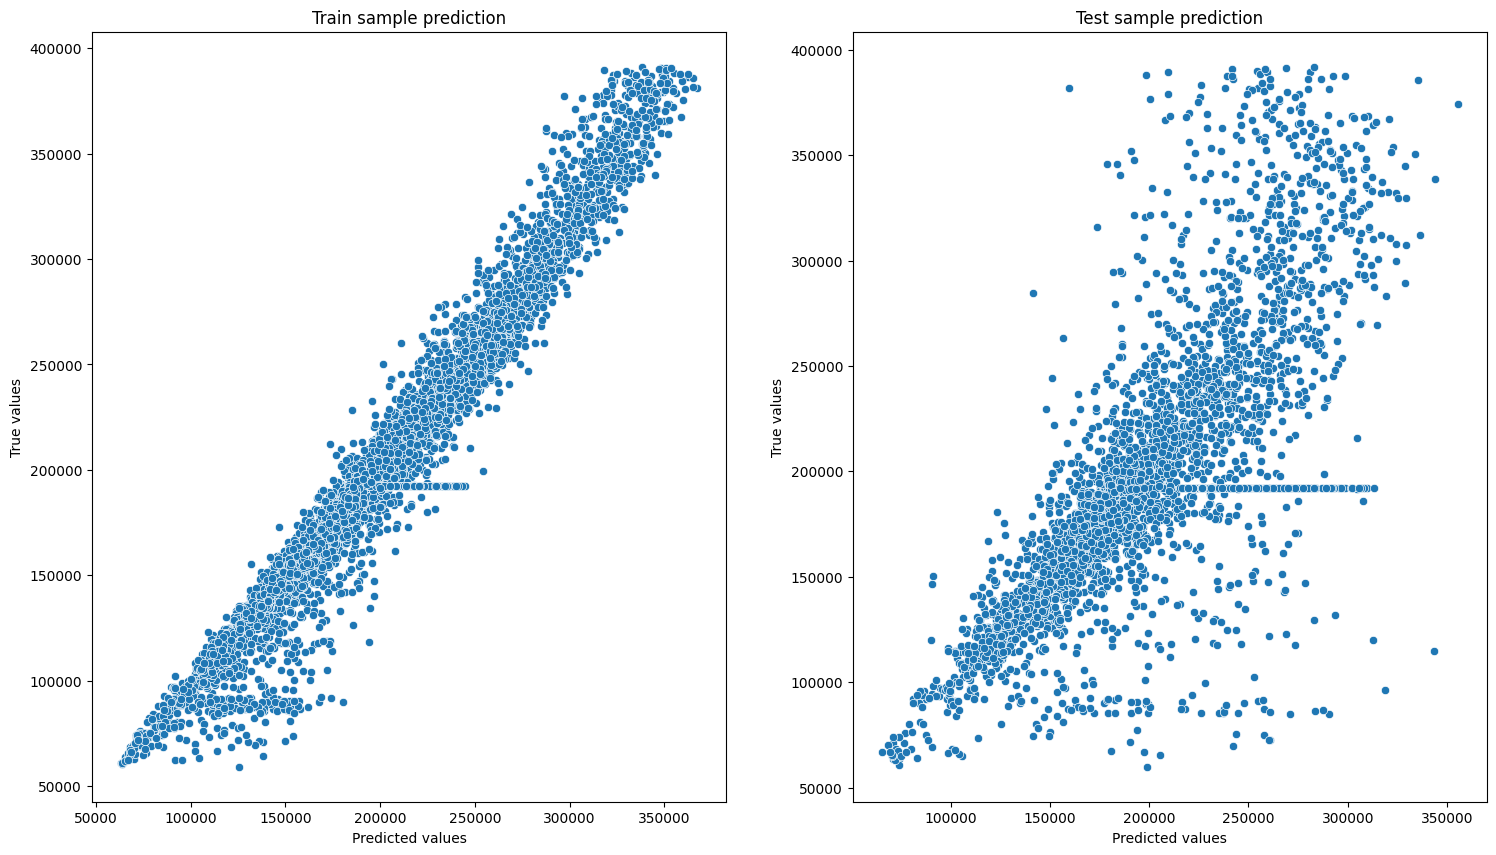

In [92]:
rf_model = RandomForestRegressor(random_state=21, criterion='squared_error')
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [93]:
#Кросс-валидация
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score.mean()

0.5657317554064177

In [94]:
#Важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
9,Social_1,0.178842
1,Rooms,0.166708
2,Square,0.122368
12,Square,0.109208
0,DistrictId,0.079735
8,Ecology_1,0.067576
3,LifeSquare,0.062100
7,HouseYear,0.055541
4,Floor,0.044314
5,KitchenSquare,0.043697


In [108]:
#test_df = pd.read_csv(folder + '/test.csv')
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['LifeSquare'].mean()
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = test_df['Healthcare_1'].mean()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   float64
 1   Rooms          5000 non-null   float32
 2   Square         5000 non-null   float32
 3   LifeSquare     5000 non-null   float32
 4   Floor          5000 non-null   float64
 5   KitchenSquare  5000 non-null   float32
 6   HouseFloor     5000 non-null   float32
 7   HouseYear      5000 non-null   float64
 8   Ecology_1      5000 non-null   float32
 9   Social_1       5000 non-null   int8   
 10  Healthcare_1   5000 non-null   float32
 11  Shops_1        5000 non-null   float64
 12  Square         5000 non-null   float32
dtypes: float32(8), float64(4), int8(1)
memory usage: 317.5 KB


In [109]:
submit = pd.read_csv(folder + '/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [110]:
predictions = rf_model.predict(test_df)
submit['Price'] = predictions
submit.head()
submit.to_csv('GolovanovaOE_price_prediction.csv', index=False)